In [3]:
import random
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import END_DATE, MONGO_URL
from scripts.analysis import data, plot

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

plot.init_matplotlib()

W, H = 6, 2.5

In [4]:
repos, stars = data.get_fake_star_repos(), data.get_fake_stars_by_month()
repos_with_campaign = data.get_repos_with_campaign()
repo_campaign_months = set(zip(stars[stars.anomaly].repo, stars[stars.anomaly].month))
repo_events = data.get_events_with_samples("repo")
actor_events = data.get_events_with_samples("actor")
repo_events.event = repo_events.event.apply(plot.shorten_gharchive_event)
actor_events.event = actor_events.event.apply(plot.shorten_gharchive_event)
repo_event_percentages = (
    repo_events.groupby(["repo", "event", "group"])["percentage"].sum().reset_index()
)
actor_event_percentages = (
    actor_events.groupby(["actor", "event", "group"])["percentage"].sum().reset_index()
)
repo_event_counts = (
    repo_events.groupby(["repo", "event", "group"])["count"].sum().reset_index()
)
actor_event_counts = (
    actor_events.groupby(["actor", "event", "group"])["count"].sum().reset_index()
)

In [5]:
# bean counting
print("# repos with suspected fake stars:", len(repos))
print(
    "# suspected fake stars:",
    sum(stars.n_stars_fake),
    ", # low activity, ",
    sum(stars.n_stars_low_activity),
    ", # clustered, ",
    sum(stars.n_stars_clustered),
)
print("# repos with suspected fake star campaigns:", len(repos_with_campaign))
print(
    "# suspected fake stars in those campaigns:",
    sum(stars[stars.repo.isin(repos_with_campaign)].n_stars_fake),
)

low_activity_actors = data.get_unique_actors(
    "low_activity_stars", {"low_activity": True}
)
clustered_actors = data.get_unique_actors("clustered_stars", {"clustered": True})
print(
    "# actors in suspected fake stars:",
    len(clustered_actors | low_activity_actors),
)

low_activity_actors_in_campaign = set()
with pymongo.MongoClient(MONGO_URL) as client:
    for star in client.fake_stars.low_activity_stars.find(
        {"low_activity": True, "repo": {"$in": list(repos_with_campaign)}}
    ):
        if (
            star["repo"] in repos_with_campaign
            and (star["repo"], star["starred_at"][:7]) in repo_campaign_months
        ):
            low_activity_actors_in_campaign.add(star["actor"])
print("# low activity stars in campaign:", len(low_activity_actors_in_campaign))

clustered_actors_in_campaign = set()
with pymongo.MongoClient(MONGO_URL) as client:
    for star in client.fake_stars.clustered_stars.find(
        {"clustered": True, "repo": {"$in": list(repos_with_campaign)}}
    ):
        if (
            star["repo"] in repos_with_campaign
            and (star["repo"], star["starred_at"][:7]) in repo_campaign_months
        ):
            clustered_actors_in_campaign.add(star["actor"])
print("# clustered actors in campaign:", len(clustered_actors_in_campaign))
print(
    "# actors in suspected fake star campaigns:",
    len(clustered_actors_in_campaign | low_activity_actors_in_campaign),
)

# repos with suspected fake stars: 26254
# suspected fake stars: 5999002.0 , # low activity,  1066934.0 , # clustered,  4932068.0
# repos with suspected fake star campaigns: 18617
# suspected fake stars in those campaigns: 3807118.0
# actors in suspected fake stars: 1501957
# low activity stars in campaign: 96309
# clustered actors in campaign: 206355
# actors in suspected fake star campaigns: 301096


In [6]:
# How many random sample repos and actors are already polluted?
sample_repo_events = pd.read_csv(f"data/{END_DATE}/sample_repo_events.csv")
sample_actor_events = pd.read_csv(f"data/{END_DATE}/sample_actor_events.csv")
print(
    f"# polluted repos in sample_repo_events: "
    f"{len(set(sample_repo_events.repo) & set(repos.repo_name))} "
    f"out of {len(sample_repo_events.repo)}",
)
print(
    f"# polluted actors in sample_actor_events: "
    f"{len(set(sample_actor_events.actor) & (clustered_actors | low_activity_actors))} "
    f"out of {len(sample_actor_events.actor)}",
)
print(
    f"After filtering: "
    f"{repo_events[repo_events.group == "Samples"].repo.nunique()} sample repos, "
    f"{actor_events[actor_events.group == "Samples"].actor.nunique()} sample actors"
)

# polluted repos in sample_repo_events: 422 out of 10000
# polluted actors in sample_actor_events: 957 out of 10000
After filtering: 9578 sample repos, 9043 sample actors


In [7]:
# face validity check: how many of the repos and actors are deleted?
deleted = repos.repo_id.isnull()
low_act = repos.n_stars_low_activity > 0
clustered = repos.n_stars_clustered > 0
campaign = repos.repo_name.isin(repos_with_campaign)
sample_repo_ids = pd.read_csv(f"data/{END_DATE}/sample_repo_ids.csv")
print(
    f"Baseline % deletion: {len(sample_repo_ids[sample_repo_ids.id.isnull()]) / len(repos) * 100:.2f}%"
)
print(
    f"% deleted in repos with fake stars: {len(repos[deleted]) / len(repos) * 100:.2f}\n"
    f"% deleted in low activity repos: {len(repos[deleted & low_act]) / len(repos[low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos: {len(repos[deleted & clustered]) / len(repos[clustered]) * 100:.2f}\n"
)
print(
    f"% deleted in repos with fake star campaigns: {len(repos[deleted & campaign]) / len(repos[campaign]) * 100:.2f}\n"
    f"% deleted in low activity repos with campaign: {len(repos[deleted & campaign & low_act]) / len(repos[campaign & low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos with campaign: {len(repos[deleted & campaign & clustered]) / len(repos[campaign & clustered]) * 100:.2f}\n"
)

fake_user_info = pd.read_csv(f"data/{END_DATE}/fake_user_info.csv")
sample_user_info = pd.read_csv(f"data/{END_DATE}/sample_user_info.csv")

deleted = fake_user_info.error.notnull()
low_act = fake_user_info.actor.isin(low_activity_actors)
clustered = fake_user_info.actor.isin(clustered_actors)
campaign = fake_user_info.actor.isin(
    clustered_actors_in_campaign | low_activity_actors_in_campaign
)
print(
    f"Baseline % deletion: {len(sample_user_info[sample_user_info.error.notnull()]) / len(repos) * 100:.2f}%"
)
print(
    f"% deleted in repos with fake stars: {len(fake_user_info[deleted]) / len(fake_user_info) * 100:.2f}\n"
    f"% deleted in low activity repos: {len(fake_user_info[deleted & low_act]) / len(fake_user_info[low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos: {len(fake_user_info[deleted & clustered]) / len(fake_user_info[clustered]) * 100:.2f}\n"
)
print(
    f"% deleted in repos with fake star campaigns: {len(fake_user_info[deleted & campaign]) / len(fake_user_info[campaign]) * 100:.2f}\n"
    f"% deleted in low activity repos with campaign: {len(fake_user_info[deleted & campaign & low_act]) / len(fake_user_info[campaign & low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos with campaign: {len(fake_user_info[deleted & campaign & clustered]) / len(fake_user_info[campaign & clustered]) * 100:.2f}\n"
)

Baseline % deletion: 5.03%
% deleted in repos with fake stars: 70.05
% deleted in low activity repos: 14.38
% deleted in clustered repos: 82.03

% deleted in repos with fake star campaigns: 90.42
% deleted in low activity repos with campaign: 79.36
% deleted in clustered repos with campaign: 90.70

Baseline % deletion: 3.54%
% deleted in repos with fake stars: 18.77
% deleted in low activity repos: 19.19
% deleted in clustered repos: 23.03

% deleted in repos with fake star campaigns: 57.07
% deleted in low activity repos with campaign: 72.29
% deleted in clustered repos with campaign: 48.83



In [8]:
fake_user_info[deleted & campaign & clustered]

,actor,raw_response,error
45,11alexlee11,NaN,GitHubAPI API returned status 404 at users/11a...
130,20kspoode,NaN,GitHubAPI API returned status 404 at users/20k...
154,2FIFaqUdo,NaN,GitHubAPI API returned status 404 at users/2FI...
155,2I2ry10VgWax,NaN,GitHubAPI API returned status 404 at users/2I2...
175,39kirGx,NaN,GitHubAPI API returned status 404 at users/39k...
...,...,...,...
9730,ya2ivanov,NaN,GitHubAPI API returned status 404 at users/ya2...
9739,yamaku4bor,NaN,GitHubAPI API returned status 404 at users/yam...
9843,youngster606,NaN,GitHubAPI API returned status 404 at users/you...
9871,yudifrozhkova,NaN,GitHubAPI API returned status 404 at users/yud...


In [9]:
repo_event_counts[repo_event_counts.repo.isin(repos_with_campaign)].groupby("event")[
    "count"
].describe()

,count,mean,std,min,25%,50%,75%,max
event,,,,,,,,
Comment,18617.0,13.603749,320.958065,0.0,0.0,0.0,0.0,21967.0
Create,18617.0,5.994253,211.046965,0.0,1.0,2.0,3.0,27119.0
Fork,18617.0,23.977225,103.734526,0.0,0.0,0.0,1.0,8509.0
Issue,18617.0,4.414030,125.653021,0.0,0.0,0.0,0.0,12710.0
Other,18617.0,4.588118,211.266713,0.0,0.0,0.0,1.0,27145.0
PR,18617.0,5.667777,106.516177,0.0,0.0,0.0,0.0,6670.0
Push,18617.0,78.848150,3947.579676,0.0,1.0,1.0,2.0,430250.0
Star,18617.0,227.959016,361.180958,50.0,91.0,152.0,262.0,20771.0


In [10]:
repo_event_counts[repo_event_counts.group == "Samples"].groupby("event")["count"].describe()

,count,mean,std,min,25%,50%,75%,max
event,,,,,,,,
Comment,9578.0,378.053978,2701.492563,0.0,1.0,15.0,94.0,100066.0
Create,9578.0,59.190228,391.516376,0.0,1.0,3.0,21.0,24132.0
Fork,9578.0,76.656713,566.954317,0.0,10.0,24.0,58.0,49614.0
Issue,9578.0,84.130612,717.033990,0.0,1.0,8.0,38.0,58716.0
Other,9578.0,55.403947,371.149715,0.0,0.0,1.0,16.0,21190.0
PR,9578.0,127.893819,748.905263,0.0,0.0,5.0,39.0,36831.0
Push,9578.0,268.189601,2506.762372,0.0,3.0,22.0,112.0,181310.0
Star,9578.0,313.393715,809.361083,50.0,71.0,116.0,241.0,21522.0


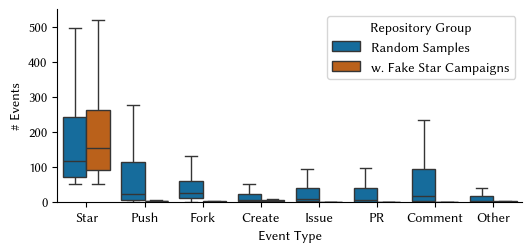

In [11]:
fig, ax = plt.subplots(figsize=(W, H))
sns.boxplot(
    x="event",
    y="count",
    data=repo_event_counts[
        repo_event_counts.repo.isin(repos_with_campaign) | (repo_event_counts.group == "Samples")
    ],
    hue="group",
    hue_order=["Samples", "Suspected Fakes"],
    order=plot.EVENT_ORDER,
    palette=["C0", "C2"],
    showfliers=False,
    ax=ax,
)
ax.set_ylabel("# Events")
ax.set_xlabel("Event Type")
handles, labels = ax.get_legend_handles_labels()
ax.legend(title="Repository Group", handles=handles, labels=["Random Samples", "w. Fake Star Campaigns"])
ax.set_ylim(0, 550)
#ax.set_yscale("log")
# ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# fig.autofmt_xdate()
fig.savefig("plots/repo-events.pdf", bbox_inches="tight", dpi=300)

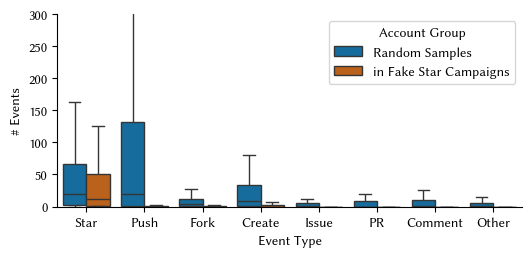

In [12]:
fig, ax = plt.subplots(figsize=(W, H))
sns.boxplot(
    x="event",
    y="count",
    data=actor_event_counts[
        actor_event_counts.actor.isin(
            clustered_actors_in_campaign | low_activity_actors_in_campaign
        )
        | (actor_event_counts.group == "Samples")
    ],
    hue="group",
    order=plot.EVENT_ORDER,
    hue_order=["Samples", "Suspected Fakes"],
    palette=["C0", "C2"],
    # errorbar="sd",
    showfliers=False,
    ax=ax,
)
ax.set_ylabel("# Events")
ax.set_xlabel("Event Type")
handles, labels = ax.get_legend_handles_labels()
ax.legend(title="Account Group", handles=handles, labels=["Random Samples", "in Fake Star Campaigns"])
ax.set_ylim(0, 300)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# fig.autofmt_xdate()
fig.savefig("plots/actor-events.pdf", bbox_inches="tight", dpi=300)

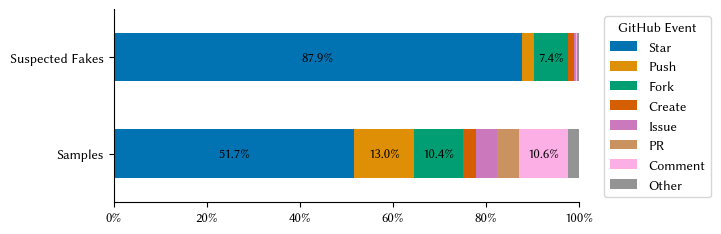

In [13]:
fig, ax = plt.subplots(figsize=(W, H))
data = (
    repo_event_percentages[
        repo_event_percentages.repo.isin(repos_with_campaign)
        | (repo_event_percentages.group == "Samples")
    ]
    .groupby(["group", "event"])["percentage"]
    .mean()
    .unstack()
)
data = data[plot.EVENT_ORDER]
data.plot.barh(stacked=True, ax=ax, color=sns.color_palette("colorblind"))
for p in ax.patches:
    if p.get_width() > 0.05:
        ax.annotate(
            f"{p.get_width() * 100:.1f}%",
            (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height() / 2 - 0.005),
            ha="center",
            va="center",
        )
ax.legend(title="GitHub Event", bbox_to_anchor=(1.3, 1))
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.set_xlim(0, 1)
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.savefig("plots/repo-event-percentage.pdf", bbox_inches="tight")

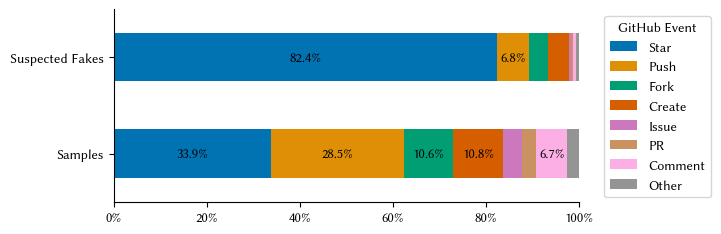

In [14]:
fig, ax = plt.subplots(figsize=(W, 2.5))
data = (
    actor_event_percentages[
        actor_event_percentages.actor.isin(
            clustered_actors_in_campaign | low_activity_actors_in_campaign
        )
        | (actor_event_percentages.group == "Samples")
    ]
    .groupby(["group", "event"])["percentage"]
    .mean()
    .unstack()
)
data = data[plot.EVENT_ORDER]
data.plot.barh(stacked=True, ax=ax, color=sns.color_palette("colorblind"))
for p in ax.patches:
    if p.get_width() > 0.05:
        ax.annotate(
            f"{p.get_width() * 100:.1f}%",
            (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height() / 2 - 0.005),
            ha="center",
            va="center",
        )
ax.legend(title="GitHub Event", loc="upper right", bbox_to_anchor=(1.3, 1))
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.set_xlim(0, 1)
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.savefig("plots/actor-event-percentage.pdf", bbox_inches="tight")

In [15]:
%%capture
# visual evaluation of post processing
"""
long_lived_repos = set(
    stars.groupby("repo").filter(lambda x: len(x) >= 3).repo.unique()
)
sample = random.sample(list(repos_with_campaign & long_lived_repos), 100)

fig, axes = plt.subplots(20, 5, figsize=(50, 80))
for i, repo in enumerate(sample):
    df = stars[stars["repo"] == repo]
    ax = axes[i // 5, i % 5]
    df.plot(kind="bar", x="month", y="n_stars", ax=ax, color="C0")
    df.plot(kind="bar", x="month", y="n_stars_fake", ax=ax, color="C1")
    ax.set_xticklabels([])
    ax.set_title(repo)
fig.savefig("plots/fake_star_campaigns.pdf")
"""

In [16]:
X_fake_repo = (
    repo_event_percentages[
        (repo_event_percentages.group == "Suspected Fakes")
        & repo_event_percentages.repo.isin(repos_with_campaign)
    ]
    .drop(columns="group")
    .pivot(columns="event", index="repo", values="percentage")
    .reset_index()
)
X_fake_actor = (
    actor_event_percentages[
        (actor_event_percentages.group == "Suspected Fakes")
        & actor_event_percentages.actor.isin(
            clustered_actors_in_campaign | low_activity_actors_in_campaign
        )
    ]
    .drop(columns="group")
    .pivot(columns="event", index="actor", values="percentage")
    .reset_index()
)
X_sample_repo = (
    repo_event_percentages[repo_event_percentages.group == "Samples"]
    .drop(columns="group")
    .pivot(columns="event", index="repo", values="percentage")
    .reset_index()
)
X_sample_actor = (
    actor_event_percentages[actor_event_percentages.group == "Samples"]
    .drop(columns="group")
    .pivot(columns="event", index="actor", values="percentage")
    .reset_index()
)

Y_repos, Y_actors = {}, {}
perplexities = [30, 50, 100]
for perplexity in perplexities:
    tSNE = TSNE(n_components=2, perplexity=perplexity, random_state=114514)
    Y_repos[perplexity] = tSNE.fit_transform(
        StandardScaler().fit_transform(
            np.concatenate(
                [
                    X_fake_repo.set_index("repo").to_numpy(),
                    X_sample_repo.set_index("repo").to_numpy(),
                ]
            )
        )
    )
    Y_actors[perplexity] = tSNE.fit_transform(
        StandardScaler().fit_transform(
            np.concatenate(
                [
                    X_fake_actor.set_index("actor").to_numpy(),
                    X_sample_actor.set_index("actor").to_numpy(),
                ]
            )
        )
    )

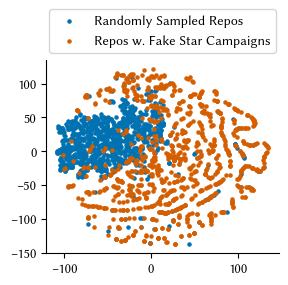

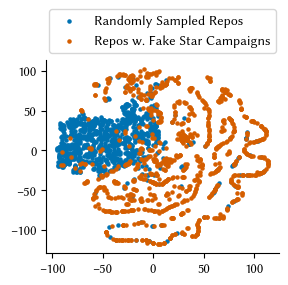

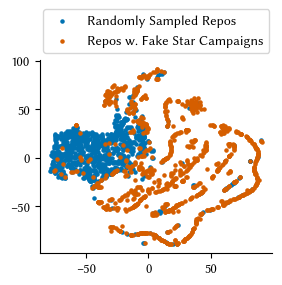

In [17]:
low_activity_ids = list(
    X_fake_actor[X_fake_actor.actor.isin(low_activity_actors)].index
)
clustered_ids = list(X_fake_actor[X_fake_actor.actor.isin(clustered_actors)].index)
sample_fakes = random.sample(range(0, len(X_fake_repo)), 1000)
sample_reals = random.sample(
    range(len(X_fake_repo), len(X_fake_repo) + len(X_sample_repo)), 1000
)

for perplexity in perplexities:
    fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
    ax.scatter(
        Y_repos[perplexity][sample_reals, 0],
        Y_repos[perplexity][sample_reals, 1],
        c="C0",
        s=5,
        label="Randomly Sampled Repos",
    )
    ax.scatter(
        Y_repos[perplexity][sample_fakes, 0],
        Y_repos[perplexity][sample_fakes, 1],
        c="C2",
        s=5,
        label="Repos w. Fake Star Campaigns",
    )
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3)),
    # ax.set_title(f"t-SNE (perplexity={perplexity})")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.savefig(f"plots/tsne-repos-{perplexity}.pdf", bbox_inches="tight", dpi=300)

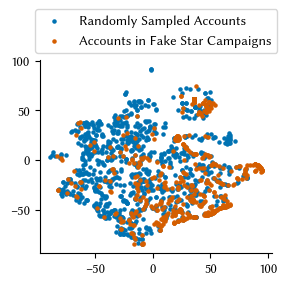

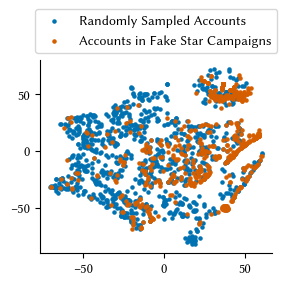

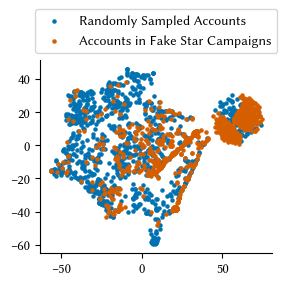

In [18]:
low_activity_ids = list(
    X_fake_actor[X_fake_actor.actor.isin(low_activity_actors)].index
)
clustered_ids = list(X_fake_actor[X_fake_actor.actor.isin(clustered_actors)].index)
sample_fakes = random.sample(range(0, len(X_fake_actor)), 1000)
sample_reals = random.sample(
    range(len(X_fake_actor), len(X_fake_actor) + len(X_sample_actor)), 1000
)

for perplexity in perplexities:
    fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
    ax.scatter(
        Y_actors[perplexity][sample_reals, 0],
        Y_actors[perplexity][sample_reals, 1],
        c="C0",
        s=5,
        label="Randomly Sampled Accounts",
    )
    ax.scatter(
        Y_actors[perplexity][sample_fakes, 0],
        Y_actors[perplexity][sample_fakes, 1],
        c="C2",
        s=5,
        label="Accounts in Fake Star Campaigns",
    )
    """
    ax.scatter(
        Y_actors[perplexity][low_activity_ids, 0],
        Y_actors[perplexity][low_activity_ids, 1],
        c="C2",
        s=5,
        alpha=1.0,
        # edgecolors="black",
        label="Stargazers with the Low Activity Heusristic",
    )
    ax.scatter(
        Y_actors[perplexity][clustered_ids, 0],
        Y_actors[perplexity][clustered_ids, 1],
        c="C3",
        s=5,
        alpha=1.0,
        # edgecolors="black",
        label="Stargazers with the Clustering Heusristic",
    )"""
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))
    #ax.set_title(f"t-SNE (perplexity={perplexity})")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.savefig(f"plots/tsne-actors-{perplexity}.pdf", bbox_inches="tight", dpi=300)